## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

## Load Data

### Customer Dataframe

In [2]:
df_cust = pd.read_csv('Customer.csv', delimiter=';')
df_cust

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


In [3]:
# checking data type

df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


```
- CustomerID is in wrong data type. It's should be object instead of int64, because they're unique number for every customer
- Income is in wrong data type. It's should be in float64 instead of object
```

In [4]:
#changing data type

df_cust['CustomerID'] = df_cust['CustomerID'].astype('object')
df_cust['Income'] = df_cust['Income'].str.replace(',', '.').astype(float)

In [5]:
# rechecking data type

df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    object 
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 17.6+ KB


In [6]:
df_cust.describe()

,Age,Gender,Income
count,447.000000,447.000000,447.000000
mean,39.782998,0.458613,8.592103
std,12.848719,0.498842,6.607065
min,0.000000,0.000000,0.000000
25%,30.000000,0.000000,4.175000
50%,39.000000,0.000000,7.520000
75%,50.500000,1.000000,10.810000
max,72.000000,1.000000,71.300000


```
- Min. age is 0. It's impossible. We need to check age column further to identify data anomaly
- Gender colum is represented in numerical but actually it's categorical. 0 for female and 1 for male.
- Min. income is 0. We need to check income column to identify data anomaly
- Age is normally distributed because mean and median of the data is near
- Income is skew to the right because median is smaller than mean
```

In [7]:
print('Age column skewness value : ',df_cust['Age'].skew())
print('Income column skewness value : ',df_cust['Income'].skew())

Age column skewness value :  0.02825086143231212
Income column skewness value :  3.21191213525306


```
- Age is normally distributed
- Income is right skewed distributed
```

In [8]:
# checking data anomaly in age column

df_cust[df_cust['Age']<17]

,CustomerID,Age,Gender,Marital Status,Income
11,12,2,1,Married,4.94
73,74,3,1,Married,5.09
127,128,0,1,Married,6.77


```
- For customerID 12 & 74, we will replace the value of age
- For customerID 128, we will drop the entire row
```

In [9]:
df_cust.drop(df_cust[df_cust['Age']==0].index, inplace=True) # deleting customer with age=0
df_cust['Age'].replace({2:20, 3:30}, inplace=True) #replacing value
df_cust[df_cust['Age']<17] # rechecking

,CustomerID,Age,Gender,Marital Status,Income


In [10]:
# checking data anomaly in income column

df_cust[df_cust['Income']==0]

,CustomerID,Age,Gender,Marital Status,Income
66,67,19,0,Single,0.0
89,90,21,1,Single,0.0
163,164,18,1,Single,0.0
225,226,18,0,Single,0.0
251,252,18,1,Single,0.0
266,267,22,0,Single,0.0
282,283,19,1,Single,0.0
284,285,20,0,Single,0.0
287,288,22,0,Single,0.0
328,329,19,1,Single,0.0


In [11]:
# checking missing value

df_cust.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [12]:
df_cust.loc[df_cust['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4.00
415,416,27,1,NaN,3.43
442,443,33,1,NaN,9.28


In [13]:
df_cust.fillna(df_cust['Marital Status'].mode()[0], inplace=True) # imputing missing value with mode

In [14]:
df_cust

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57
...,...,...,...,...,...
442,443,33,1,Married,9.28
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81


In [15]:
# checking duplicated data

df_cust.duplicated().sum()

0

`No duplicated data in customer dataframe`

### Product Dataframe

In [16]:
df_prod = pd.read_csv('Product.csv', delimiter=';')
df_prod

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


In [17]:
print(df_prod.info())
print(df_prod.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
None
              Price
count     10.000000
mean   10410.000000
std     4890.455557
min     3200.000000
25%     7825.000000
50%     9700.000000
75%    14250.000000
max    18000.000000


### Store Dataframe

In [18]:
df_store = pd.read_csv('Store.csv', delimiter=';')
df_store

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
5,6,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
6,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"
7,8,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


In [19]:
print(df_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
None


### Transaction Dataframe

In [20]:
df_trx = pd.read_csv('Transaction.csv', delimiter=';')
df_trx

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4
...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13


In [21]:
# checking data type

df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


```
- CustomerID and StoreID are in wrong data type. They're should be object instead of int64, because they're unique number for every customer and store
- Date is in wrong data type. It's should be in datetime instead of object
```

In [22]:
# changing data type

df_trx['Date'] = pd.to_datetime(df_trx['Date'])
df_trx['CustomerID'] = df_trx['CustomerID'].astype('object')
df_trx['StoreID'] = df_trx['StoreID'].astype('object')

In [23]:
# rechecking data type

df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   object        
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 313.9+ KB


`All columns are in correct data type`

In [24]:
# checking missing value

df_trx.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

`No missing value in transaction dataframe`

In [25]:
# checking duplicated data

df_trx.duplicated().sum()

0

`No duplicated data in transaction dataframe`

## Machine Learning Regression (Time Series)

In [26]:
# grouping transaction dataframe based on sum of quantity sold product

df_ts = df_trx.groupby('Date', as_index=False)['Qty'].sum()
df_ts

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


`We only use transaction dataframe for time series case because we only need date and quantity columns, so we don't need to merge transaction dataframe with other dataframes`

In [27]:
# making date column as index for time series dataframe

df_ts.set_index('Date', inplace=True)
df_ts

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


### Splitting Dataset into Train & Test

In [28]:
# checking index for splitting data

train_size = 0.8*len(df_ts)
train_size

292.0

`Data is splitted into train and test set with composition 80% train set and 20% test set`

In [29]:
# splitting data

train = df_ts[:292]
test = df_ts[292:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (292, 1)
Test size :  (73, 1)


### Time Series Decomposition

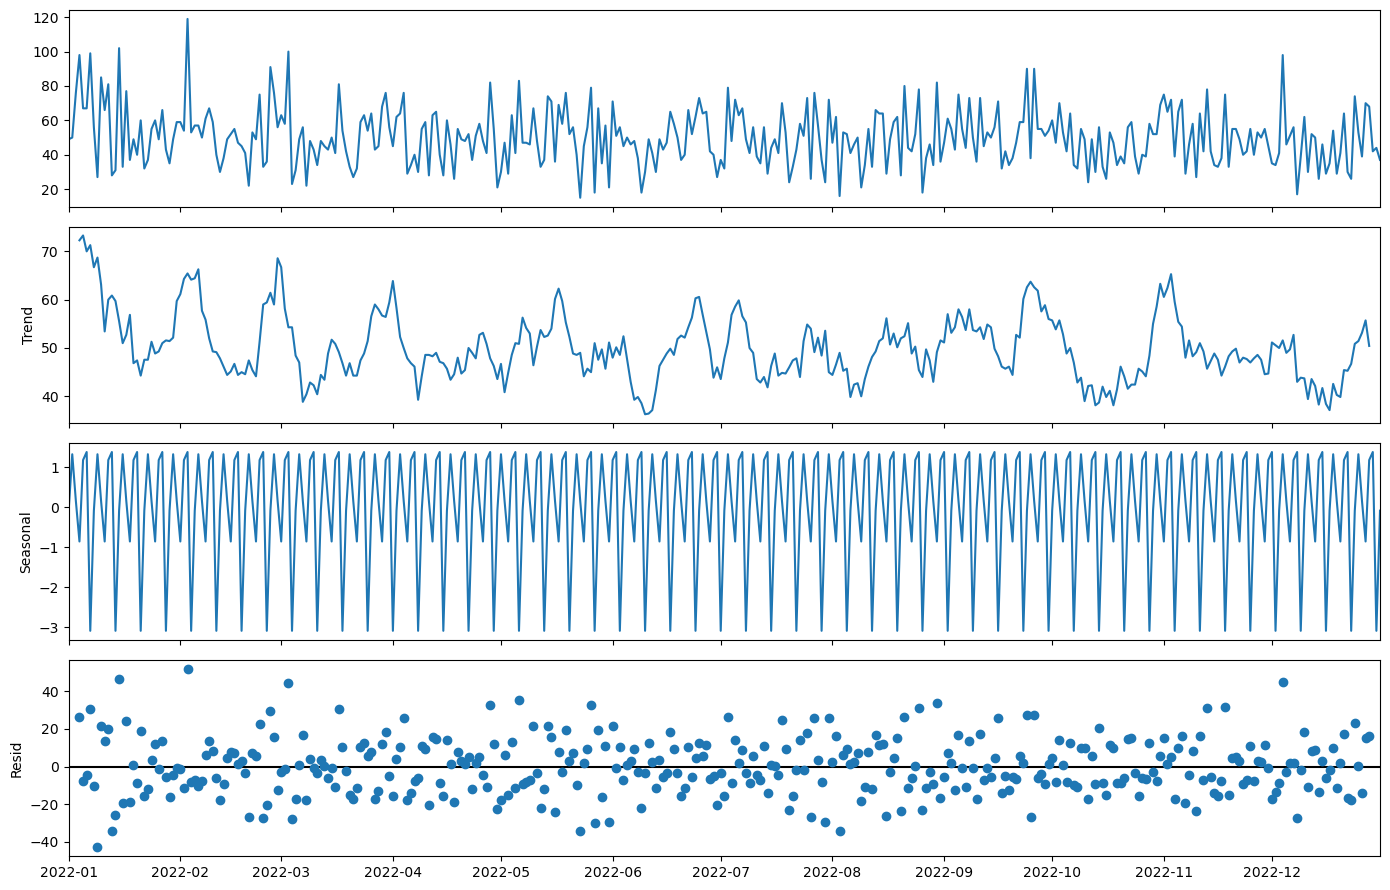

In [30]:
# visualizing data, trend, seasonality, and residual

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_ts,model='additive')
ax=res.plot()
plt.show()

### Checking Stationarity

In [31]:
# creating a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [32]:
# checking stationarity from train set

check_stationarity(train['Qty'])

ADF Statistic: -16.986059
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Stationary


`Train set is already stationary, so we don't need to difference the train set. For ARIMA model, if the data is stationary, then d=0`

### Plotting ACF & PACF

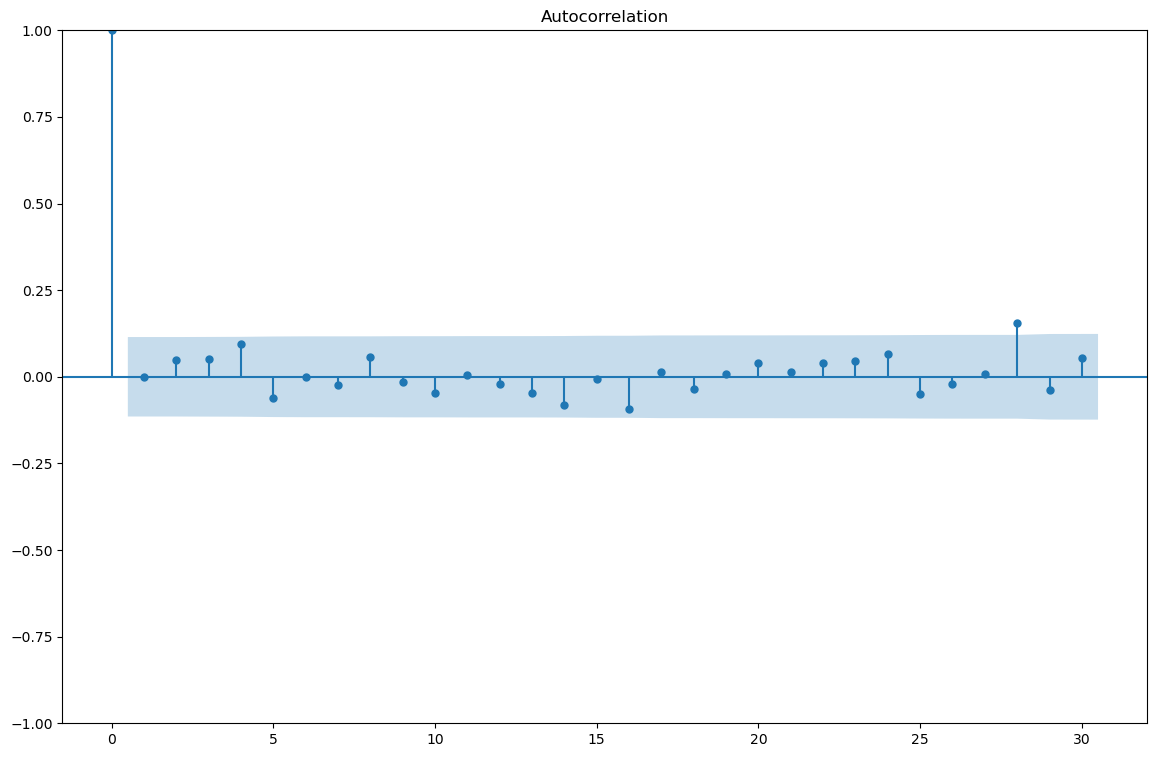

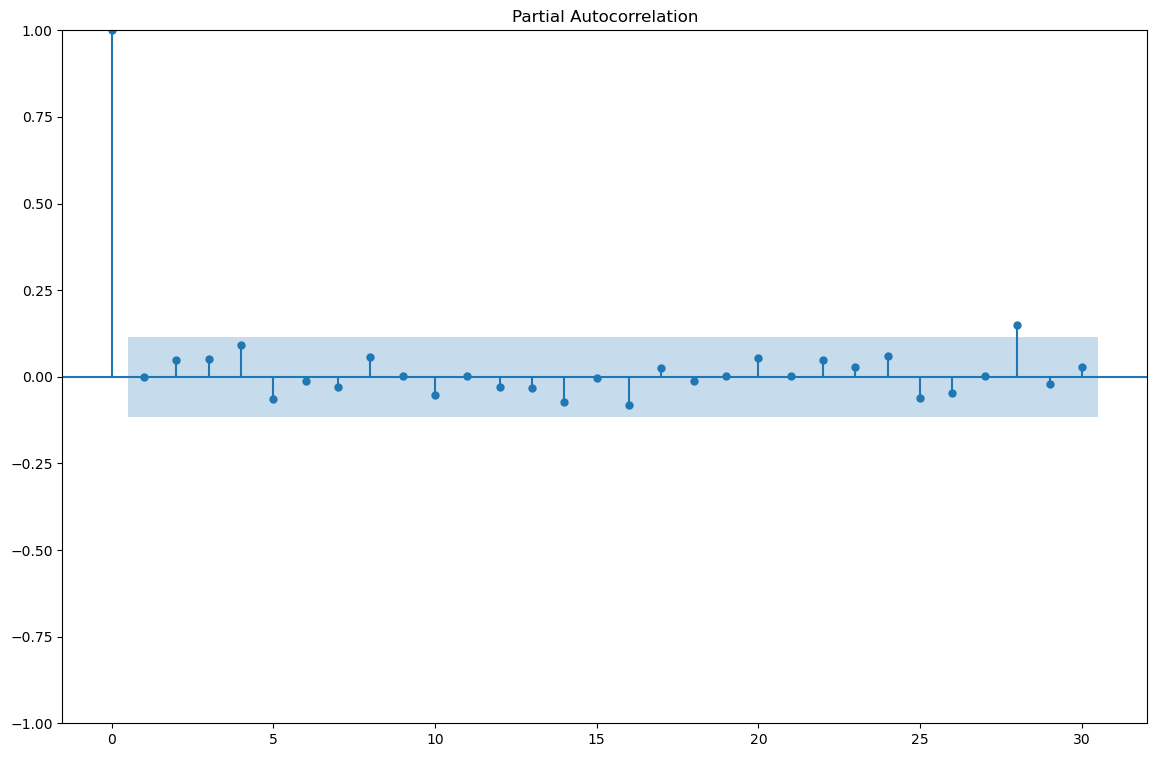

In [33]:
# plotting ACF & PACF to determine p,q for ARIMA model

plot_acf(train['Qty'], lags=30)
plot_pacf(train['Qty'], lags=30)
plt.show()

```
- PACF cut off in 28th lag, that means value for p=28
- ACF cut off in 28th lag, that means value for q=28
```

### Modelling & Predicting

In [34]:
# training the model based on order that we get from previous cell 

order = (28, 0, 28)
model = ARIMA(train, order=order)
model_fit = model.fit()

In [35]:
# predicting

predictions = model_fit.forecast(steps=len(test))

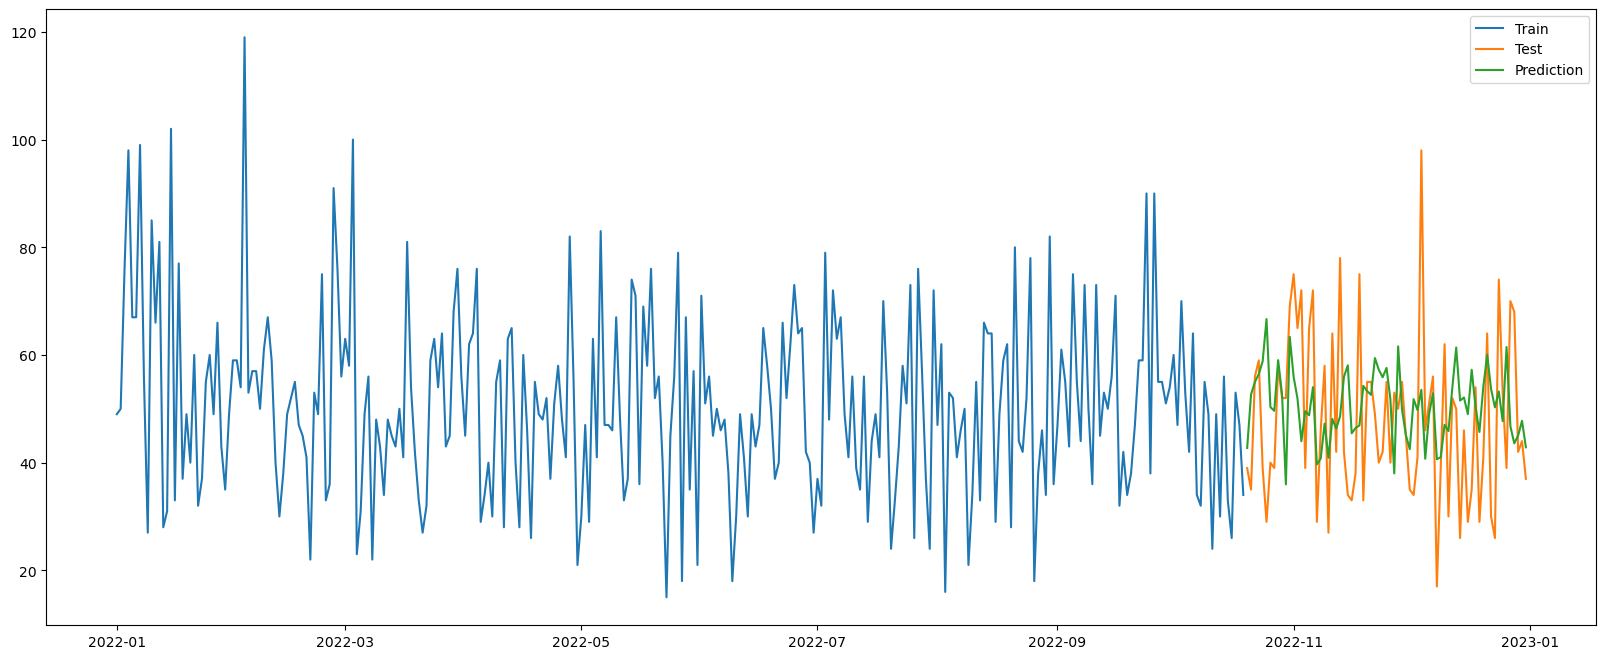

In [36]:
# visualizing the result of prediction compared to train and test set

plt.figure(figsize=(20,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Prediction')
plt.legend(loc='best')
plt.show()

### Model Evaluation

In [37]:
# calculating evaluation metrics for regression

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

print("mae :",mae)
print("rmse :",rmse)

mae : 13.000288880955754
rmse : 15.984890791244794


## Machine Learning Clustering

In [38]:
df_clus = df_trx.merge(df_cust, on='CustomerID', how='left') # joining transaction and customer dataframe
df_clus

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36.0,0.0,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44.0,1.0,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27.0,1.0,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48.0,1.0,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33.0,0.0,Married,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR54423,243,2022-12-31,P10,15000,5,75000,3,38.0,0.0,Married,3.34
5016,TR5604,271,2022-12-31,P2,3200,4,12800,9,29.0,0.0,Married,4.74
5017,TR81224,52,2022-12-31,P7,9400,6,56400,9,37.0,0.0,Married,3.73
5018,TR85016,18,2022-12-31,P8,16000,3,48000,13,47.0,0.0,Married,13.60


In [39]:
df_clus.isnull().sum() # checking missing value

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Age               9
Gender            9
Marital Status    9
Income            9
dtype: int64

`There are 9 missing values. It happen because we deleted 1 customerID with Age column's value is zero `

In [40]:
df_clus[df_clus['CustomerID']==128] # 128 is customer ID that was already deleted in previous process

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
483,TR42721,128,2022-04-02,P4,12000,1,12000,14,NaN,NaN,NaN,NaN
484,TR5327,128,2022-04-02,P8,16000,2,32000,13,NaN,NaN,NaN,NaN
2053,TR15094,128,2022-05-28,P4,12000,1,12000,5,NaN,NaN,NaN,NaN
2665,TR70093,128,2022-09-07,P9,10000,6,60000,6,NaN,NaN,NaN,NaN
4204,TR54394,128,2022-01-11,P4,12000,5,60000,9,NaN,NaN,NaN,NaN
4283,TR47154,128,2022-08-11,P9,10000,2,20000,1,NaN,NaN,NaN,NaN
4320,TR23475,128,2022-11-11,P8,16000,3,48000,6,NaN,NaN,NaN,NaN
4712,TR30456,128,2022-09-12,P7,9400,3,28200,2,NaN,NaN,NaN,NaN
4973,TR48093,128,2022-12-28,P2,3200,7,22400,11,NaN,NaN,NaN,NaN


In [41]:
df_clus.dropna(inplace=True) # deleting every rows with missing value

In [42]:
df_clus

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36.0,0.0,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44.0,1.0,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27.0,1.0,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48.0,1.0,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33.0,0.0,Married,6.95
...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR54423,243,2022-12-31,P10,15000,5,75000,3,38.0,0.0,Married,3.34
5016,TR5604,271,2022-12-31,P2,3200,4,12800,9,29.0,0.0,Married,4.74
5017,TR81224,52,2022-12-31,P7,9400,6,56400,9,37.0,0.0,Married,3.73
5018,TR85016,18,2022-12-31,P8,16000,3,48000,13,47.0,0.0,Married,13.60


In [43]:
aggregation = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum',
    'Age': 'first',
    'Income': 'first'}

cluster = df_clus.groupby('CustomerID', as_index=False).agg(aggregation) #making new dataframe by grouping dataframe based on list of aggregate
cluster

,CustomerID,TransactionID,Qty,TotalAmount,Age,Income
0,1,17,60,623300,55.0,5.12
1,2,13,57,392300,60.0,6.23
2,3,15,56,446200,32.0,9.17
3,4,10,46,302500,31.0,4.87
4,5,7,27,268600,58.0,3.57
...,...,...,...,...,...,...
441,443,16,59,485100,33.0,9.28
442,444,18,62,577700,53.0,15.31
443,445,18,68,587200,51.0,14.48
444,446,11,42,423300,57.0,7.81


In [44]:
cluster.drop('CustomerID', axis=1, inplace=True) # deleting customerID column

In [45]:
cluster

,TransactionID,Qty,TotalAmount,Age,Income
0,17,60,623300,55.0,5.12
1,13,57,392300,60.0,6.23
2,15,56,446200,32.0,9.17
3,10,46,302500,31.0,4.87
4,7,27,268600,58.0,3.57
...,...,...,...,...,...
441,16,59,485100,33.0,9.28
442,18,62,577700,53.0,15.31
443,18,68,587200,51.0,14.48
444,11,42,423300,57.0,7.81


In [46]:
df_eda = cluster.copy()

In [47]:
# looping to check skewness from every columns

for i in cluster.columns:
    print(i, ': ', cluster[i].skew())

TransactionID :  0.18084300508599138
Qty :  0.2604463605661973
TotalAmount :  0.4690257438310846
Age :  0.16663583189627718
Income :  3.207350072235121


`All of columns is normally distributed except Income column. Income column is right skewed distributed`

### Handling Outliers

In [48]:
# checking the percentage of outliers from Income column

Q1 = cluster['Income'].quantile(.25)
Q3 = cluster['Income'].quantile(.75)
IQR = Q3 - Q1
upper = Q3 + (3*IQR)
lower = Q1 - (3*IQR)
outlier = cluster[(cluster['Income'] <= lower) | (cluster['Income'] >= upper)]

print('outliers percentage : ', len(outlier)/cluster['Income'].shape[0] * 100, '%')

outliers percentage :  0.8968609865470852 %


In [49]:
# checking percentage of outliers from normally distributed columns

for i in cluster[['TransactionID','Qty','TotalAmount','Age']]:
    rata2 = cluster[i].mean()
    upper = rata2 + (3*(cluster[i].std()))
    lower = rata2 - (3*(cluster[i].std()))
    outlier = cluster[(cluster[i] <= lower) | (cluster[i] >= upper)]

    print(i,'outliers percentage : ', len(outlier)/cluster[i].shape[0] * 100, '%')

TransactionID outliers percentage :  0.2242152466367713 %
Qty outliers percentage :  0.0 %
TotalAmount outliers percentage :  0.672645739910314 %
Age outliers percentage :  0.0 %


In [50]:
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

In [51]:
# winsorizing outliers for right skewed distribution

wins_skw = Winsorizer(capping_method='iqr', fold=3, tail='both', variables=['Income'])
cluster = wins_skw.fit_transform(cluster)

In [52]:
# winsorizing outliers for normal distribution

wins_nrm = Winsorizer(capping_method='gaussian', fold=3, tail='both', variables=['TransactionID','TotalAmount'])
cluster = wins_nrm.fit_transform(cluster)

### Feature Scaling

In [53]:
scaler = MinMaxScaler()
cluster = pd.DataFrame(scaler.fit_transform(cluster))
cluster.columns = scaler.get_feature_names_out()
cluster.head()

,TransactionID,Qty,TotalAmount,Age,Income
0,0.779243,0.724638,0.824406,0.685185,0.166328
1,0.556602,0.681159,0.465901,0.777778,0.202388
2,0.667922,0.666667,0.549552,0.259259,0.297897
3,0.389621,0.521739,0.326534,0.240741,0.158207
4,0.222641,0.246377,0.273923,0.740741,0.115975


### Silhouette Method

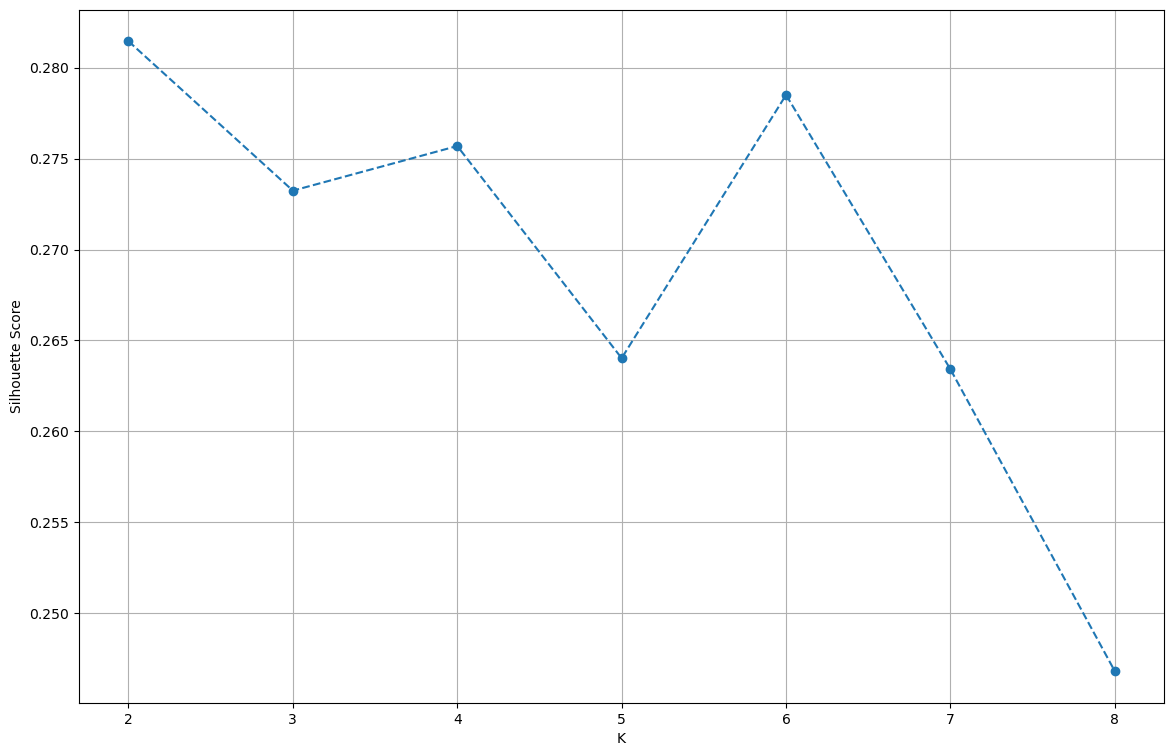

In [54]:
K=[2,3,4,5,6,7,8]
s_score_slc=[silhouette_score(cluster, KMeans(n_clusters=i,n_init='auto',random_state=34).fit(cluster).labels_) for i in K]

plt.plot(K,s_score_slc,'o--')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

`We choose 3 as number of cluster`

In [63]:
kmn =  KMeans(n_clusters=3,random_state=34)  
df_eda['cluster'] = kmn.fit_predict(cluster)  # making new column with clustering prediction as value 
df_eda

,TransactionID,Qty,TotalAmount,Age,Income,cluster
0,17,60,623300,55.0,5.12,0
1,13,57,392300,60.0,6.23,0
2,15,56,446200,32.0,9.17,0
3,10,46,302500,31.0,4.87,2
4,7,27,268600,58.0,3.57,1
...,...,...,...,...,...,...
441,16,59,485100,33.0,9.28,0
442,18,62,577700,53.0,15.31,0
443,18,68,587200,51.0,14.48,0
444,11,42,423300,57.0,7.81,1


In [64]:
df_eda.groupby('cluster')[['TransactionID','Qty','TotalAmount','Age','Income']].mean() # grouping dataframe based on cluster

,TransactionID,Qty,TotalAmount,Age,Income
cluster,,,,,
0,14.671233,54.938356,497462.328767,38.828767,8.026301
1,9.937931,34.813793,303807.586207,51.813793,13.148759
2,9.212903,33.529032,290753.548387,29.974194,4.874129


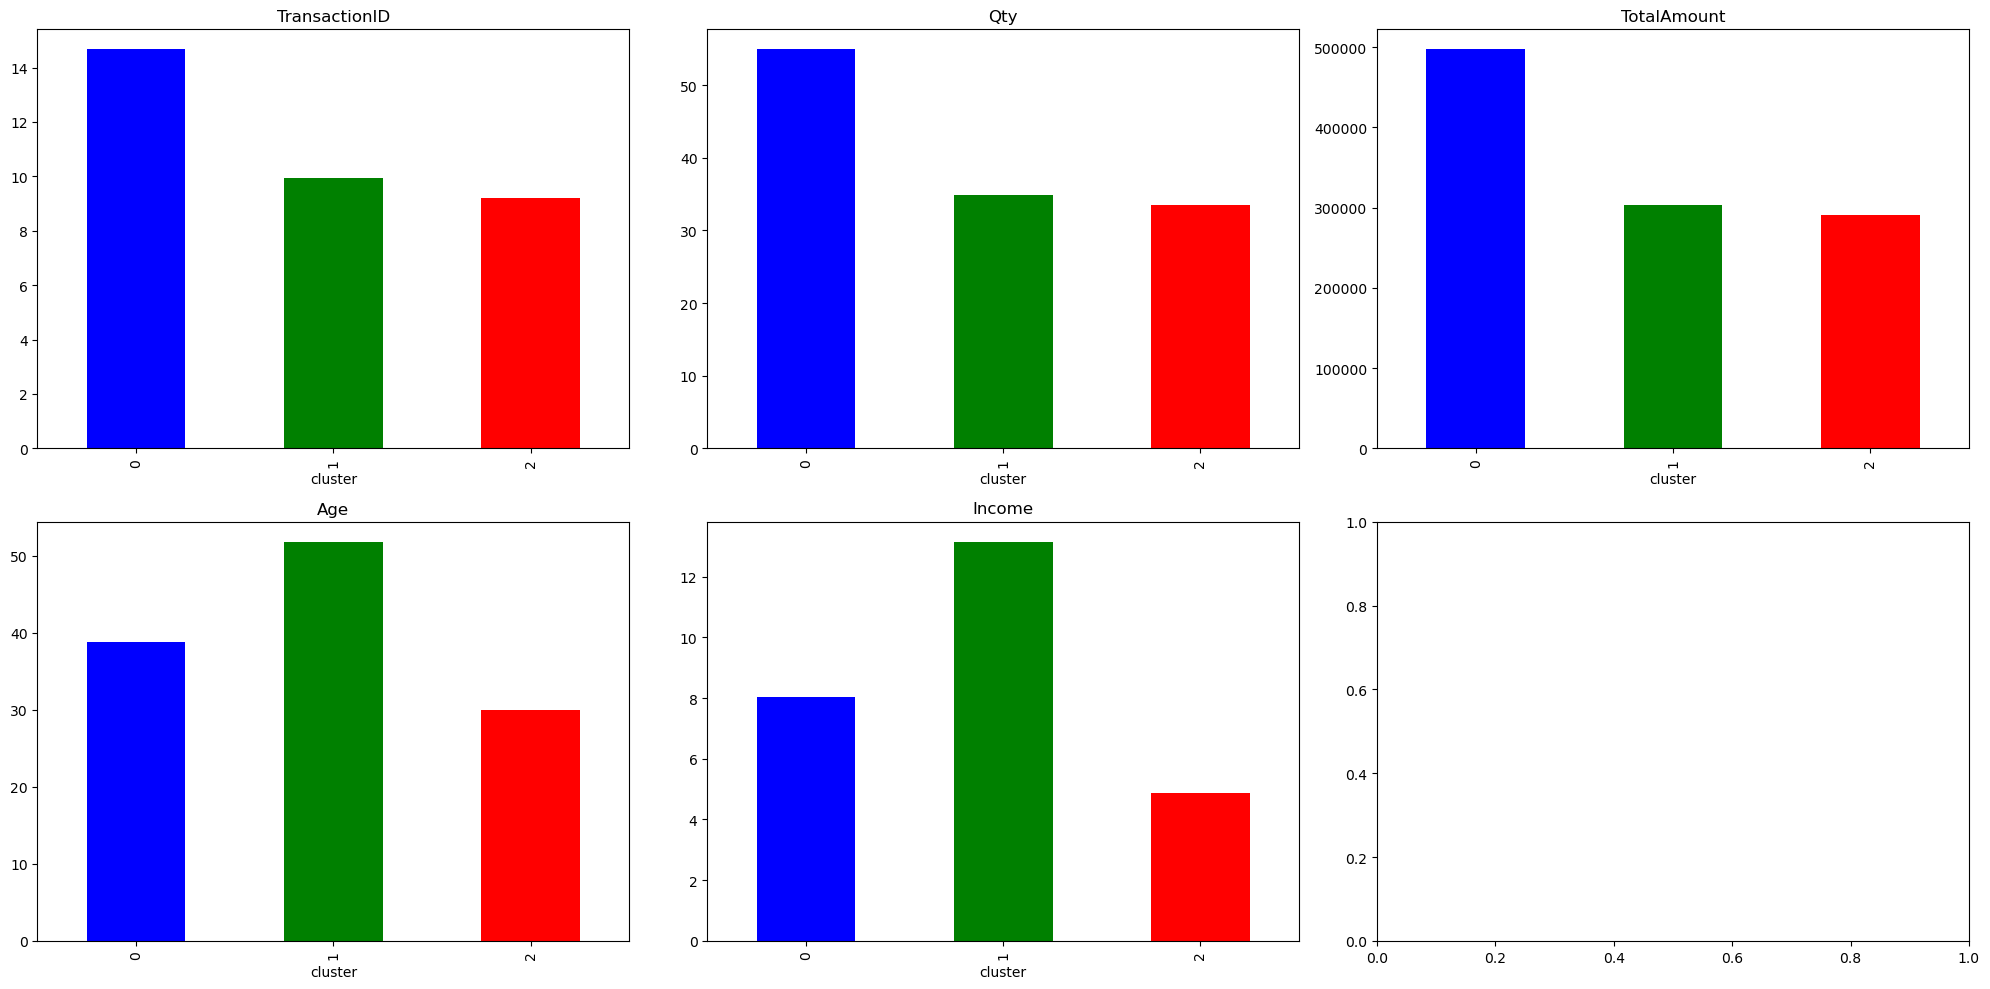

In [65]:
# visualizing columns based on cluster

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (feature, title) in enumerate(zip(df_eda.iloc[:, :5].columns, df_eda.iloc[:, :5].columns)):
    ax = axes[i // 3, i % 3]
    df_eda.groupby('cluster')[feature].mean().plot(kind='bar', ax=ax,color=['blue','green','red'])
    ax.set_title(title)

plt.tight_layout()
plt.show()

### Characteristic of cluster & Recommendation

```
- Cluster 0 : middle income customer with average of their age is 38, high transaction, quantity, and automatically high spending
- Cluster 1 : high income customer with average of their age is 51, more transaction than cluster 2 but relatively same  quantity and spending
- Cluster 2 : low incom customer with average of their age is 29, low transaction, quantity, and spending

Recommendations :
- Cluster 0 : 
    1. Personalized Recommendations: Use their transaction history to provide personalized product recommendations.
    2. High-Value Discounts: Offer discounts for high-value purchases to encourage them to spend even more
- Cluster 1 :
    1. VIP Services: Provide them with VIP treatment, such as dedicated customer service, express shipping, or extended warranties
    2. Promote them with healthy products
- Cluster 2 :
    1. Affordable Options: Focus on promoting budget-friendly products
    2. Discounts and Bargains: Offer discounts, flash sales, or clearance sales to attract cost-conscious shoppers.
    3. Bundled Savings: Create bundles of products that offer savings compared to buying items individually.
```